# Neural decoding: position and direction

Here is a full example of using the tools in the `fklab.decode` module to perform spike-sorting-less decoding of a subject's position **and running direction** in a maze from spiking activity recorded on multiple tetrodes. To check decoding performance, we perform cross-validation in which each trial is used in turn to test the encoding model that is built from the other trials.

## imports

In [ ]:
# import numerical libraries
import numpy as np
import scipy.interpolate

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import fklab.utilities.yaml as yaml

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# finally, import the decoding tools
import fklab.decode

## retrieve data

In [ ]:
import pathlib

root_path = pathlib.Path("~/notebook_data_cache").expanduser()
path = root_path.joinpath("decoding")

if not path.exists():
    path.mkdir(parents=True)

datafile = path.joinpath("processed_data.hdf5")

if not datafile.exists():
    from fklab.io.cloud import dropboxAPI

    dbx = dropboxAPI.from_token(
        os.environ.get("BITBUCKET_TOKEN")
    )  # Replace by your own token
    dbx.download("/Data/decoding/processed_data.hdf5", datafile)

## define parameters
Here we set parameters for data processing and decoding.

In [ ]:
# define trial epochs
trials = fklab.segments.Segment(
    [[2100, 2250], [2250, 2355], [2355, 2455], [2455, 2550], [2550, 2650]]
)
ntrials = len(trials)

# select spike data
tt_selection = [
    "TT1",
    "TT15",
    "TT16",
    "TT17",
    "TT19",
    "TT20",
    "TT23",
    "TT24",
    "TT5",
]  # tetrodes to be used for decoding
amp_threshold = (
    70.0  # uV, only use spikes with maximum amplitude larger than this threshold
)

# set kernel bandwidths and compression for encoding
pos_bw = 5.0  # cm, default spatial kernel bandwidth
amp_bw = 30.0  # uV, default spike amplitude kernel bandwidth
compression = 1.0  # kernel density compression Mahalanobis distance threshold

# set evaluation grid resolution
fine_grid_resolution = 2.0
# cm, spatial grid used to build squared distance matrix
grid_resolution = 4.0
# cm, spatial grid for decoding (should be multiple of fine grid)

# set behavior options
stim_sampling_frequency = 25.0  # Hz, sampling frequency of position tracking
speed_threshold = 10.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

# set decoding options
decode_bin = 0.1  # seconds, bin size for run decoding

## maze definition and evaluation grid
Here we define the maze. Since the maze has multiple sections that meet at choice point, the maze is represented as a graph. Distances on the graph cannot simply be computed as the difference between (linearized) positions, so we precompute a squared distance matrix for a set of finely spaced linearized points on the maze.

In [ ]:
# define full maze
maze = "maze:\n  comments: ''\n  shapes:\n    track:\n      tags: [track]\n      comments: ''\n      shape: !graph_shape\n        nodes:\n        - [233.0, 145.0]\n        - [184.0, 145.0]\n        - [174.0, 168.0]\n        - [172.0, 120.0]\n        - [87.0, 245.0]\n        - [138.0, 0.0]\n        polylines:\n        - !polyline_shape\n          vertices:\n          - [233.0, 145.0]\n          - [184.0, 145.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [174.0, 168.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [184.0, 145.0]\n          - [172.0, 120.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [174.0, 168.0]\n          - [87.0, 245.0]\n          spline: false\n        - !polyline_shape\n          vertices:\n          - [172.0, 120.0]\n          - [138.0, 0.0]\n          spline: false\n    start:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [230.95882352941175, 144.93529411764706]\n        size: [40.92690758786794, 47.01063709417264]\n        orientation: 0.021273386024061366\n    B:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [142.0, 14.000000000000016]\n        size: [44.384682042344295]\n        orientation: 2.891149563978441\n    A:\n      tags: [field, ' reward']\n      comments: ''\n      shape: !rectangle_shape\n        center: [97.0, 238.0]\n        size: [42.5205832509386]\n        orientation: 2.4227626539681686\n"
maze = yaml.load(maze, Loader=yaml.FullLoader)

# construct fine grid for complete track and compute squared distance matrix
fine_grid = np.arange(
    0, maze["maze"]["shapes"]["track"]["shape"].pathlength, fine_grid_resolution
)
fine_gridx, fine_gridy = np.meshgrid(fine_grid, fine_grid)
distances = (
    maze["maze"]["shapes"]["track"]["shape"].distance(fine_gridx, fine_gridy) ** 2
)

/home/jovyan/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# discretize position on track
maze_shape = maze["maze"]["shapes"]["track"]["shape"]
if isinstance(maze_shape, fklab.geometry.shapes.graph):
    pos_bins, nbins, binsize = maze_shape.bin(fine_grid_resolution, separate=True)
else:
    pos_bins, nbins, binsize = maze_shape.bin(fine_grid_resolution)

fine_grid = (pos_bins[:-1] + pos_bins[1:]) / 2.0  # position bin centers

# compute squared distance matrix
x, y = np.meshgrid(fine_grid, fine_grid)
distances = maze_shape.distance(x, y)
distances = distances**2

## preprocess behavioral and spiking data
Here we load the data and map (x,y) coordinates to (linearized) position on the maze. Since we use a distance matrix, we then need to map linearized position to indices into the fine grid that was used to compute the distance matrix.

In [ ]:
# load behavioral and ephys data
f = h5py.File(datafile, "r")
behavior = f["training/behavior"]

# map all xy positions to maze
linear_pos = maze["maze"]["shapes"]["track"]["shape"].point2path(
    behavior["positionsXY"][:]
)[0]
# map linearized positions to the fine grid vector
pos = scipy.interpolate.interp1d(
    fine_grid, np.arange(len(fine_grid)), kind="nearest", bounds_error=False
)(linear_pos)

# create nearest neighbor interpolators for mapped positions for future use
linear_pos_interpolator = scipy.interpolate.interp1d(
    behavior["time"], linear_pos, kind="nearest", bounds_error=False
)
pos_interpolator = scipy.interpolate.interp1d(
    behavior["time"], pos, kind="nearest", bounds_error=False
)

In [ ]:
import fklab.signals.smooth.kernelsmoothing as ks

linear_vel = maze["maze"]["shapes"]["track"]["shape"].gradient(
    linear_pos, 1 / stim_sampling_frequency
)
linear_vel = ks.smooth1d(linear_vel, bandwidth=0.5, delta=1 / stim_sampling_frequency)
run_dir = (linear_vel > 0).astype(float)  # True=1=outbound, False=0=inbound
dir_interpolator = scipy.interpolate.interp1d(
    behavior["time"], run_dir, kind="nearest", bounds_error=False
)

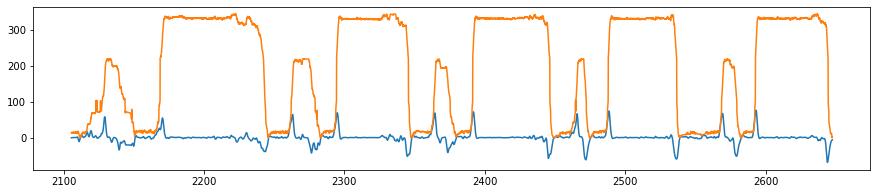

In [ ]:
# double check linear position and velocity
plt.figure(figsize=(15, 3))
plt.plot(behavior["time"][:], linear_vel)
plt.plot(behavior["time"][:], linear_pos)

Next, we extract the times and amplitudes for all spikes on the selected tetrodes that meet the minimum amplitude requirement.

In [ ]:
# for each selected tetrode extract the times and amplitudes for all
# spikes with maximum amplitude larger than threshold
tt_data = f["training/ephys/MUA/tetrodes"]
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    selection = [
        np.max(tt_data[tt][1:, :], axis=0) > amp_threshold for tt in tt_selection
    ]
tt_time = [tt_data[tt][:][0, sel] for tt, sel in zip(tt_selection, selection)]
tt_amp = [tt_data[tt][:][1:, sel].T for tt, sel in zip(tt_selection, selection)]
tt_pos = [
    np.concatenate([pos_interpolator(t)[:, None], dir_interpolator(t)[:, None]], axis=1)
    for t in tt_time
]
# tt_pos = [ dir_interpolator(t)[:,None] for t in tt_time ]

And we construct a list of run epochs where the subject ran faster than the speed threshold.

In [ ]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        behavior["speed"][:] > speed_threshold, behavior["time"][:]
    )

## define decoding spaces and grid
To set up the encoding model, we first define the stimulus space, the spike amplitude space and the stimulus grid on which we will evaluate the posterior distribution.

In [ ]:
# construct a encoded space for the subject's position with default kernel bandwidth
# using the precomputed squared distance matrix
pos_space = fklab.decode.EncodedSpace("position", distances=distances, bandwidth=pos_bw)
# construct a categorical space with two levels for running direction
dir_space = fklab.decode.CategoricalSpace("direction", ["inbound", "outbound"])
# construct multiplicative position-by-direction space
space = fklab.decode.MultiSpace([pos_space, dir_space])

# construct a coarse grid for evaluation by skipping N points in the fine grid
pos_grid = pos_space.grid(int(round(grid_resolution / fine_grid_resolution)))
grid_vector = fine_grid[:: int(round(grid_resolution / fine_grid_resolution))]

# construct direction grid
dir_grid = dir_space.grid()

# construct full grid
grid = space.grid([pos_grid, dir_grid])

# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = fklab.decode.EuclideanSpace(
    ["amp{0}".format(x) for x in range(4)],
    bandwidth=[
        amp_bw,
    ]
    * 4,
)

## convenience function for building decoder and binning data
For cross-validation, we need to rebuild the encoding model for different training data sets, and decode different test data sets. Below we define a decoder factory function that will accept all our stimulus and spike data and return a function that will build a new decoder for us given a set of training epochs.

In [ ]:
def decoder_build_factory(**kwargs):

    kwd = {
        "stimulus_space",
        "grid",
        "stimulus_duration",
        "compression",
        "stimulus",
        "stimulus_time",
        "event_time",
        "event_stimulus",
        "event_data",
        "event_space",
        "random",
    }

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # first create a Stimulus object that represents the stimulus probability density
        stim = fklab.decode.Stimulus(
            kwargs["stimulus_space"],
            kwargs["grid"],
            kwargs["stimulus_duration"],
            kwargs["compression"],
        )
        stim.random_insertion = kwargs["random"]
        stim.add_stimuli(
            kwargs["stimulus"][epochs.contains(kwargs["stimulus_time"])[0]]
        )

        # then build the likelihoods for each of the sources (tetrodes)
        likelihoods = []
        for event_time, event_stimulus, event_data in zip(
            kwargs["event_time"], kwargs["event_stimulus"], kwargs["event_data"]
        ):
            selection = epochs.contains(event_time)[
                0
            ]  # select events within training epochs
            L = fklab.decode.PoissonLikelihood(kwargs["event_space"], stim)
            L.random_insertion = kwargs["random"]
            L.add_events(
                np.concatenate(
                    (event_data[selection], event_stimulus[selection]), axis=1
                )
            )
            likelihoods.append(L)

        # build decoder from likelihoods
        decoder = fklab.decode.Decoder(likelihoods, [])

        return decoder

    return fcn

In [ ]:
# let's use the factory function to create our decoder building function for our data
data = dict(
    stimulus_space=space,
    grid=grid,
    stimulus_duration=1.0 / stim_sampling_frequency,
    compression=compression,
    stimulus=np.concatenate([pos[:, None], run_dir[:, None]], axis=1),
    stimulus_time=behavior["time"][:],
    event_time=tt_time,
    event_data=tt_amp,
    event_stimulus=tt_pos,
    event_space=spike_space,
    random=False,
)

build_decoder = decoder_build_factory(**data)

We will use the same factory approach for constructing the test data sets.

In [ ]:
def data_build_factory(**kwargs):

    kwd = {"decode_bin", "event_time", "event_data"}

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # split epochs into smaller bins for decoding
        decode_segments = epochs.split(size=kwargs["decode_bin"])
        bins = [
            decode_segments.contains(x, expand=True)[2] for x in kwargs["event_time"]
        ]

        # extract event data for each decoding bin
        data = [
            [
                np.zeros((0, x.shape[1]))
                if len(b[s]) == 1 and b[s][0] == -1
                else x[b[s], :]
                for x, b in zip(kwargs["event_data"], bins)
            ]
            for s in range(len(decode_segments))
        ]

        return decode_segments, data

    return fcn

In [ ]:
# let's use the factory function to create our data building function for our data
data = dict(decode_bin=decode_bin, event_time=tt_time, event_data=tt_amp)

build_data = data_build_factory(**data)

## perform cross-validation
Here we perform the cross-validation by looping through all trials and using the current trial to generate the test data set and the other trials to create the encoding model/decoder. Finally, we compute and collect the decoding error.

In [ ]:
# create lists for collecting real position, estimates and errors
pos_reals = []
pos_estimates = []
pos_errors = []

dir_reals = []
dir_estimates = []
dir_errors = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data

for test_trial in range(ntrials):

    # set training epochs to all trials except the test trial
    training_epochs = run_epochs.intersection(
        trials[[trial for trial in range(ntrials) if trial != test_trial]]
    )

    # construct decoder for current training epochs
    decoder = build_decoder(training_epochs)

    # test data during run maze arm runs for test trial only
    test_epochs = run_epochs.intersection(trials[test_trial])

    # extract event data for each time bin
    decode_segments, data = build_data(test_epochs)

    # perform decoding and concatenate posteriors
    posterior = [decoder.decode(x, decode_bin, True) for x in data]
    posterior = np.vstack(posterior)

    # compute MAP estimates
    n, shape = posterior.shape[0], posterior.shape[1:]
    max_posterior = np.unravel_index(
        np.argmax(posterior.reshape((n, -1)), axis=1), shape
    )
    max_posterior = np.column_stack(max_posterior)
    # max_posterior = np.unravel_index( np.argmax(posterior, axis=1), grid.shape )
    pos_estimates.append(grid_vector[max_posterior[:, 0]])
    dir_estimates.append(max_posterior[:, 1])

    # determine real stimulus values
    pos_reals.append(linear_pos_interpolator(decode_segments.center))
    dir_reals.append(dir_interpolator(decode_segments.center))

    # compute errors
    pos_errors.append(
        np.abs(
            maze["maze"]["shapes"]["track"]["shape"].distance(
                pos_estimates[-1], pos_reals[-1]
            )
        )
    )
    dir_errors.append(dir_estimates[-1] != dir_reals[-1])

pos_estimates = np.concatenate(pos_estimates)
pos_reals = np.concatenate(pos_reals)
pos_errors = np.concatenate(pos_errors)

dir_estimates = np.concatenate(dir_estimates)
dir_reals = np.concatenate(dir_reals)
dir_errors = np.concatenate(dir_errors)

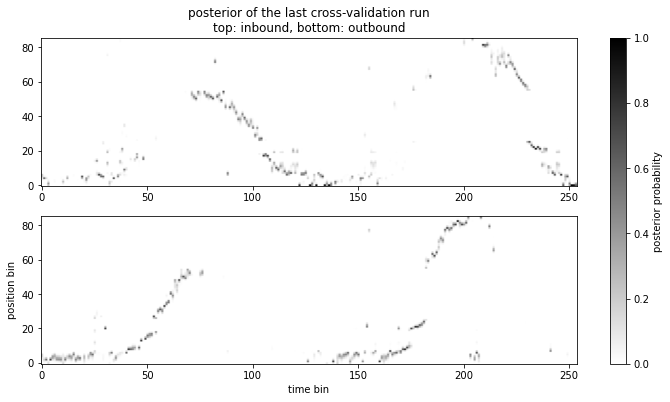

In [ ]:
# let's check if decoding worked by looking at the last posterior
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

img = ax[0].imshow(
    posterior.reshape((254,) + tuple(grid.shape))[:, :, 0].T,
    aspect="auto",
    origin="lower",
    cmap="gray_r",
    vmin=0,
    vmax=1,
)
ax[0].set(
    title="posterior of the last cross-validation run\ntop: inbound, bottom: outbound"
)

img = ax[1].imshow(
    posterior.reshape((254,) + tuple(grid.shape))[:, :, 1].T,
    aspect="auto",
    origin="lower",
    cmap="gray_r",
    vmin=0,
    vmax=1,
)

plt.colorbar(img, ax=ax, label="posterior probability")

ax[1].set(xlabel="time bin", ylabel="position bin");

## assess decoding results

In [ ]:
# get borders between maze section in linearized position
nodes = np.cumsum(
    [
        0.0,
    ]
    + maze["maze"]["shapes"]["track"]["shape"].edgelengths.tolist()
)
nsections = len(nodes) - 1

estimated_section = np.digitize(pos_estimates, nodes) - 1
real_section = np.digitize(pos_reals, nodes) - 1

# compute error statistics
median_error = np.median(pos_errors)
correct = 100.0 * np.mean(estimated_section == real_section)

# compute error statistics per maze section
median_error_by_section = [
    np.median(
        pos_errors[np.logical_and(pos_reals >= nodes[k], pos_reals < nodes[k + 1])]
    )
    for k in range(nsections)
]
correct_by_section = [
    100.0 * np.mean(estimated_section[real_section == k] == k) for k in range(nsections)
]

overall median error is 5.8cm
median error per maze section is 5.8cm, 5.0cm, 4.5cm, 5.8cm, 6.4cm
overall % correct maze section is 89%
% correct per maze section is 90%, 69%, 88%, 90%, 92%
% correct direction is 79%


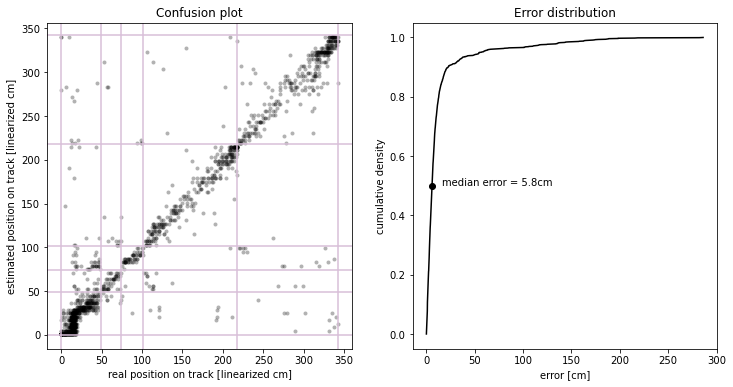

In [ ]:
# plot confusion matrix: true position vs estimated position
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(
    pos_reals, pos_estimates, "ko", alpha=0.3, markersize=4, markeredgecolor="none"
)
ax[0].set_ylabel("estimated position on track [linearized cm]")
ax[0].set_xlabel("real position on track [linearized cm]")
ax[0].set_title("Confusion plot")

# plot maze section borders
for val in nodes:
    ax[0].axhline(val, color="thistle")
    ax[0].axvline(val, color="thistle")

# plot error distribution
def ecdf(x):
    return np.sort(x), np.arange(1, len(x) + 1, dtype=float) / len(x)


x, y = ecdf(pos_errors)

ax[1].plot(x, y, "k")
ax[1].set_ylabel("cumulative density")
ax[1].set_xlabel("error [cm]")
ax[1].set_title("Error distribution")
ax[1].plot(median_error, 0.5, "ko")
ax[1].text(median_error + 10, 0.5, "median error = {0:0.1f}cm".format(median_error))

# print summary statistic
print("overall median error is {0:0.1f}cm".format(median_error))
print(
    "median error per maze section is "
    + ", ".join(["{0:0.1f}cm".format(x) for x in median_error_by_section])
)

print("overall % correct maze section is {0:0.0f}%".format(correct))
print(
    "% correct per maze section is "
    + ", ".join(["{0:0.0f}%".format(x) for x in correct_by_section])
)

print("% correct direction is {:0.0f}%".format(100 * (1 - np.mean(dir_errors))))

## Look at occupancy and spike rates

In [ ]:
# build decoder for all run data
decoder = build_decoder(run_epochs.intersection(trials))

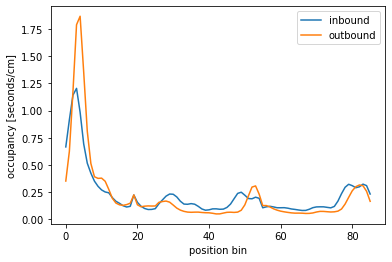

In [ ]:
occupancy = decoder.stimulus().occupancy()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for k, label in enumerate(["inbound", "outbound"]):
    ax.plot(occupancy[:, k], label=label)

ax.set(xlabel="position bin", ylabel="occupancy [seconds/cm]")
ax.legend();

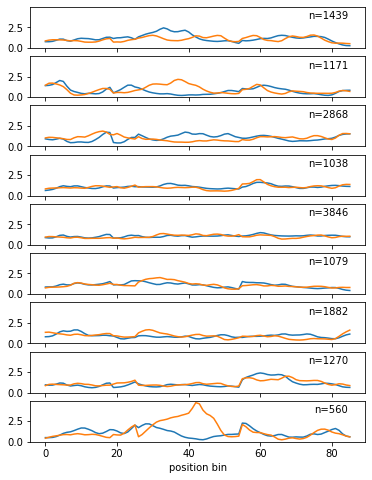

In [ ]:
fig, ax = plt.subplots(decoder.nsources, 1, sharex=True, sharey=True, figsize=(6, 8))

for source, _ax in enumerate(ax):
    likelihood = decoder.likelihood(source)
    likelihood.precompute()
    # print(l.event_distribution.ncomponents)
    _ax.plot(likelihood.event_rate)
    _ax.text(
        0.95,
        0.9,
        "n={}".format(likelihood.event_distribution.ncomponents),
        ha="right",
        va="top",
        transform=_ax.transAxes,
    )

ax[-1].set(ylim=(0, None), xlabel="position bin");